In [1]:
#here I am installing and importing stuff we need 

#!pip install numpy --upgrade
#!sudo pip install nilearn
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import os
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats
from sklearn.manifold import MDS
import scipy.spatial.distance as sp_distance

import nibabel as nib
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker

from sklearn.svm import LinearSVC
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
#here I try but do not succeed to get the files from the drive.
# Because this did not work for me, I just put the files here on the left in the colab directory
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from nilearn import datasets
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')

import os

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1hUWlEFZJKjCdfgmaLFFwhNbQkOEZWEKE' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  print(fname)
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)


with open(fname, 'r') as f:
  print(f.read())

title: .ipynb_checkpoints, id: 1j8L8-HBzh4xxuBZRJb1nCReJLWNW_Lk4
downloading to /root/data/.ipynb_checkpoints
/root/data/.ipynb_checkpoints


FileNotDownloadableError: ignored

In [0]:
# Here I load the nifty files
# I loaded just 4 
from nibabel.testing import data_path
import nibabel as nib

#this method converts a subject to an array
def convert_path_to_image_array (path):
  img = nib.load(path)
  array = img.get_data()
  return array

hariri_path = "drive/My Drive/brain project/data_social_anxiety/social_anxiety_sagol/hariri/faces_vs_shapes/"
doors_path = "drive/My Drive/brain project/data_social_anxiety/social_anxiety_sagol/doors/win_vs_loss/"
rois_path = "drive/My Drive/brain project/ROIs/"

subjects = []
for i in range(50):
sample_1 = convert_path_to_image_array(hariri_path + 'sub-120con_0001.nii')
sample_2 = convert_path_to_image_array(hariri_path + 'sub-121con_0001.nii')
sample_3 = convert_path_to_image_array(hariri_path + 'sub-122con_0001.nii')
sample_4 = convert_path_to_image_array(hariri_path + 'sub-123con_0001.nii')

mask_nucleus_accumbens = convert_path_to_image_array(rois_path + 'rNAcc_L.nii')  

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/ma/core.py:711: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


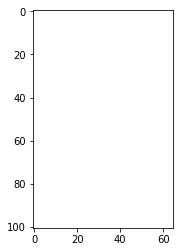

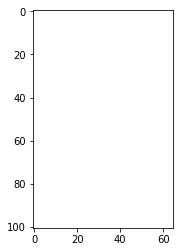

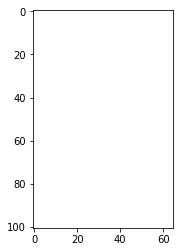

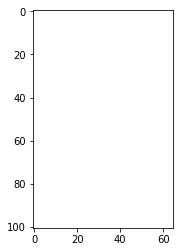

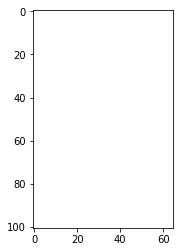

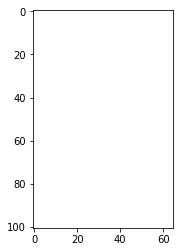

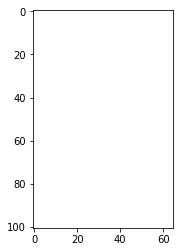

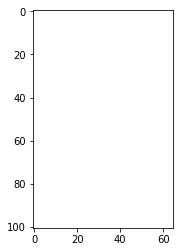

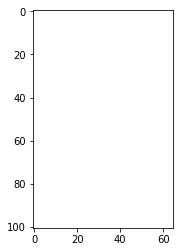

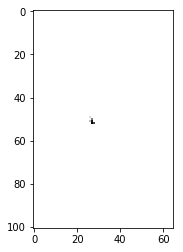

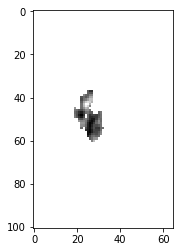

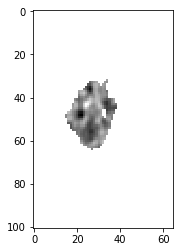

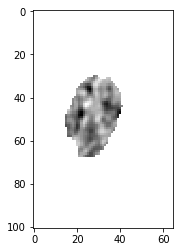

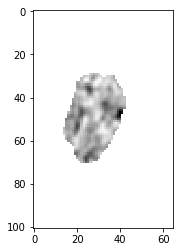

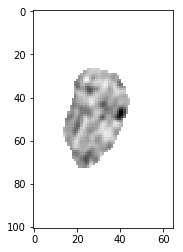

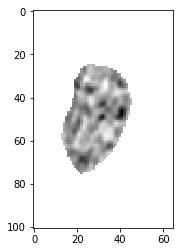

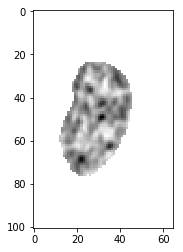

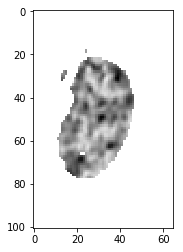

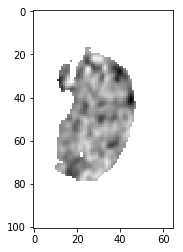

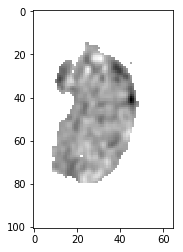

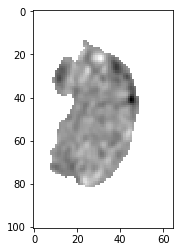

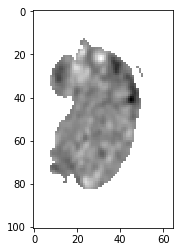

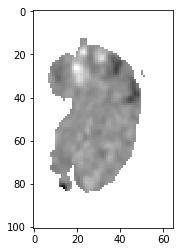

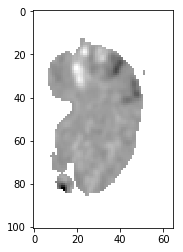

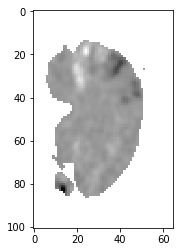

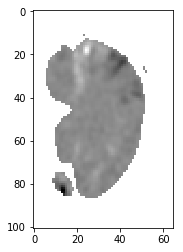

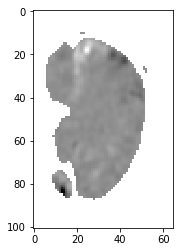

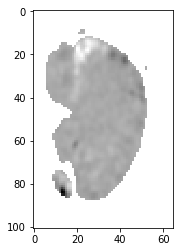

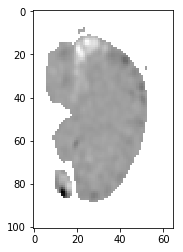

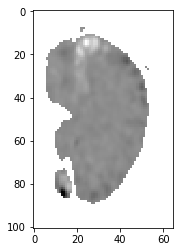

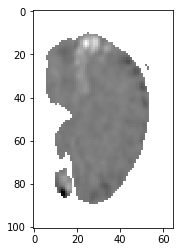

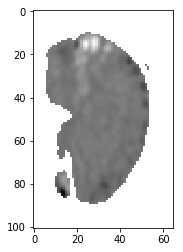

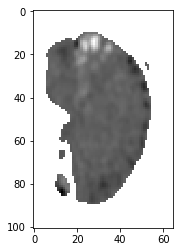

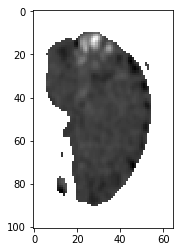

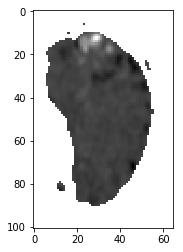

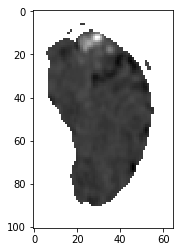

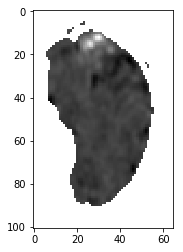

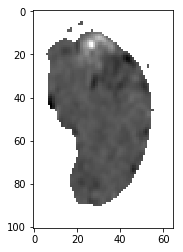

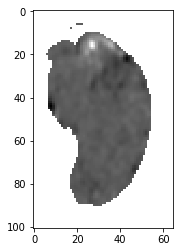

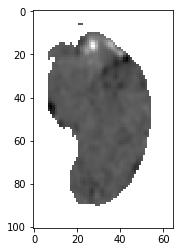

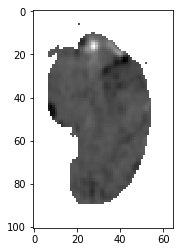

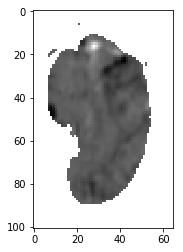

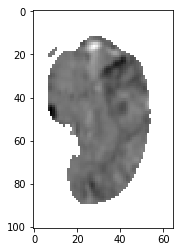

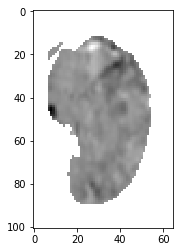

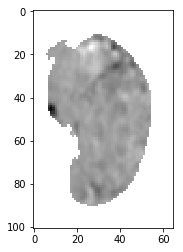

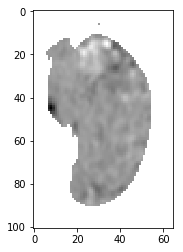

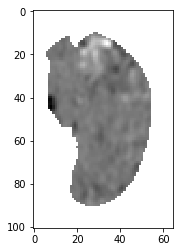

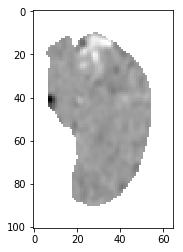

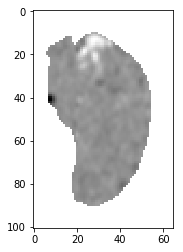

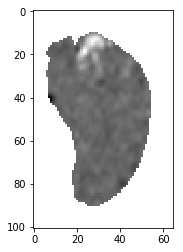

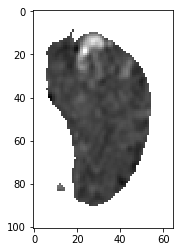

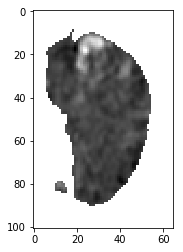

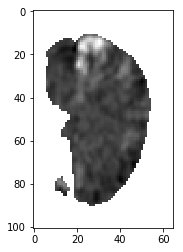

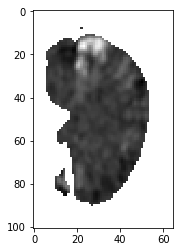

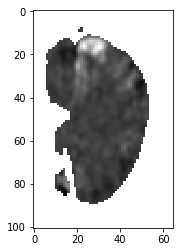

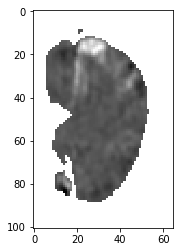

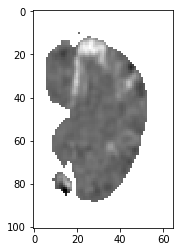

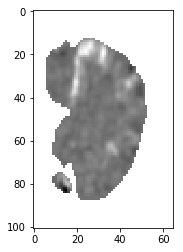

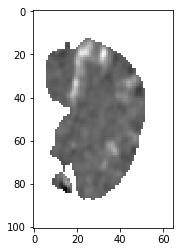

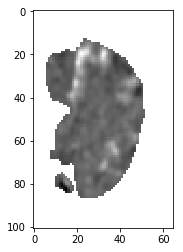

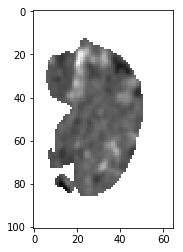

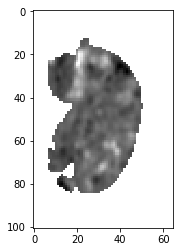

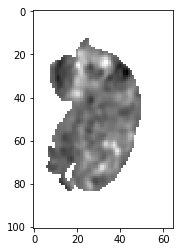

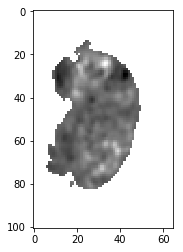

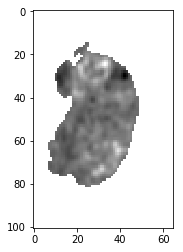

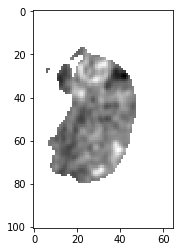

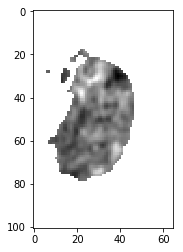

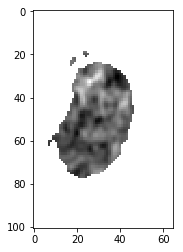

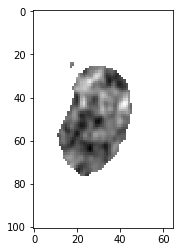

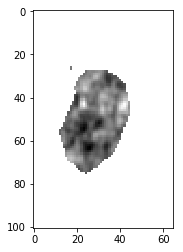

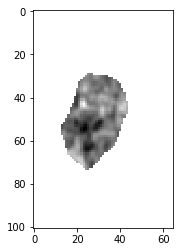

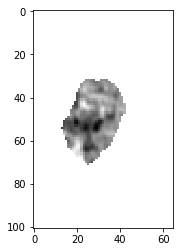

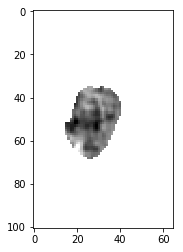

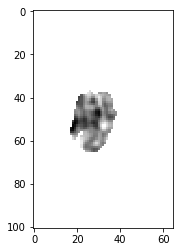

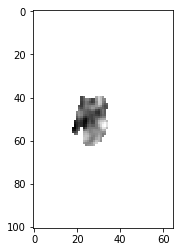

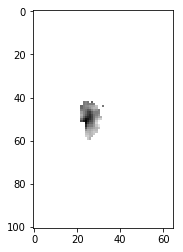

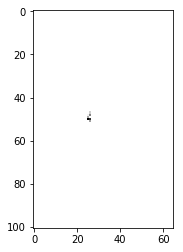

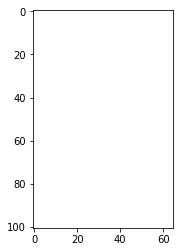

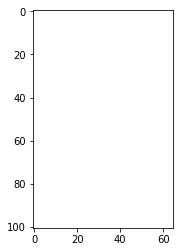

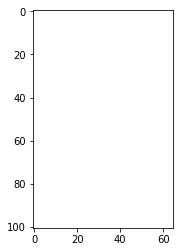

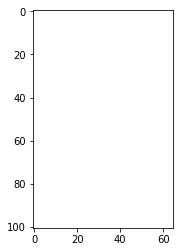

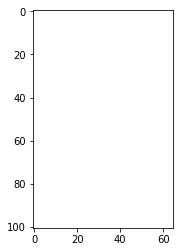

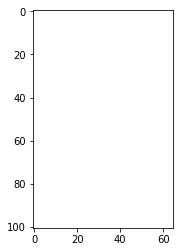

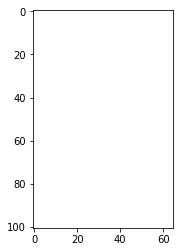

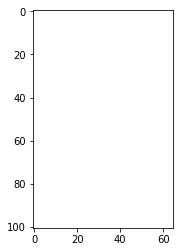

In [14]:
data_shape = sample_1.shape # the shape of the array is 85*101*65
size_of_vector = data_shape[0]*data_shape[1]*data_shape[2]
data_samples_as_arrays = [sample_1, sample_2, sample_3, sample_4]
data_samples_as_arrays_no_nans = []

#images of brain
import matplotlib.pyplot as plt

for i in range(4):
  data_samples_as_arrays_no_nans.append(data_samples_as_arrays[i])


for i in range(sample_1.shape[0]):
  plt.imshow(data_samples_as_arrays_no_nans[0][i], cmap="gray")
  plt.show()

data_samples_as_vectors = [0 for i in range (4)]
#here I make it a vector and turn nans to zeros
for i in range(len(data_samples_as_arrays)):
  data_samples_as_vectors[i] = np.nan_to_num(data_samples_as_arrays[i].reshape(size_of_vector))

In [9]:
# This function masks a sample with a masker 
# It is only multiplying since the mask is all 0's in places we dont want
# and all 1's in places we want (places in the ROI)
def mask_with_masker(masker_as_vector, sample_to_mask):
  return np.multiply(masker_as_vector, sample_to_mask)
  

mask_nucleus_accumbens_as_vector =  np.nan_to_num(mask_nucleus_accumbens.reshape(size_of_vector))

masked = mask_with_masker(mask_nucleus_accumbens_as_vector, data_samples_as_vectors[0])

for i in range (size_of_vector):
  if (masked[i]!=0.0):
    print (i)
    print(masked[i])

233696
-0.06366457
233761
-0.11661885
233762
-0.049520764
240261
-0.18748134
240262
-0.16997331
240326
-0.38555223
240327
-0.33161542
240391
-0.555103
240392
-0.41254154
246826
-0.029186472
246827
-0.09280792
246891
-0.4084044
246892
-0.38955885
246893
-0.19100235
246956
-0.77712715
246957
-0.5802389
246958
-0.24008103
247022
-0.5187983
253392
-0.023217527
253393
-0.0147764385
253457
-0.31146932
253458
-0.16080838
253459
0.030918151
253522
-0.49988252
253523
-0.13144806
253524
0.059401274
259958
-0.22699174
259959
-0.11701444
260023
-0.2417278
260024
-0.017041408
260088
-0.135553
260089
0.06403604


In [0]:
# now if you want to get to a certain cell:
#I added this just to show you that not all of them are zeros (but most of them are)
sample_1 = data_samples_as_vectors[0]
for i in range(85*101*65):
  if (sample_1[i] !=0.0):
    print(sample_1[i], i)
    break

-0.08643544 62296


In [0]:
# Here I do predictions on this 4 samples,
# with SVR - it is an SVM which does regression
# and on a random y labels

from sklearn.svm import SVR

n_samples = len(data_samples_as_vectors)
n_features = 85*101*65

rng = np.random.RandomState(1)
X = rng.randn(n_samples, n_features)
for i in range (n_samples):
  X[i] = data_samples_as_vectors[i]

#TODO: load our chosen y labels
Y = rng.randn(n_samples)
#the real labels of fpes copied from the excel: questionaries by task
subject_120_fpes = 23
subject_121_fpes = 27
subject_122_fpes = 1
subject_123_fpes = 26

Y[0] = subject_120_fpes
Y[1] = subject_121_fpes
Y[2] = subject_122_fpes
Y[3] = subject_123_fpes


clf = SVR(gamma='scale', C=1.0, epsilon=0.2)
clf.fit(X, Y)
print("first label is {} and prediction is {}".format(Y[0], clf.predict(X[0].reshape(1,-1))))
print("second label is {} and prediction is {}".format(Y[1], clf.predict(X[1].reshape(1,-1))))
print("third label is {} and prediction is {}".format(Y[2], clf.predict(X[2].reshape(1,-1))))
print("fourth label is {} and prediction is {}".format(Y[3], clf.predict(X[3].reshape(1,-1))))





first label is 23.0 and prediction is [23.6260854]
second label is 27.0 and prediction is [25.21076372]
third label is 1.0 and prediction is [23.6167128]
fourth label is 26.0 and prediction is [25.37391459]


Now I try to do what was done here with nilearn:
https://nilearn.github.io/auto_examples/02_decoding/plot_haxby_multiclass.html#sphx-glr-auto-examples-02-decoding-plot-haxby-multiclass-py

and here

https://nilearn.github.io/decoding/decoding_intro.html#loading-and-preparing-the-data

and here they predicted age from fMRI with nilearn with a network called spaceNet:

https://nilearn.github.io/auto_examples/02_decoding/plot_oasis_vbm_space_net.html#sphx-glr-auto-examples-02-decoding-plot-oasis-vbm-space-net-py

In [0]:

# Here I try to implement the spaceNet thing on our 4 samples.
# it is not working since it is not enough samples
# thats the code they used: https://nilearn.github.io/modules/generated/nilearn.decoding.SpaceNetRegressor.html#nilearn.decoding.SpaceNetRegressor


n_subjects = 4  # increase this number if you have more RAM on your box
imgs_paths = ['sub-120con_0001.nii', 'sub-121con_0001.nii', 'sub-122con_0001.nii', 'sub-123con_0001.nii']

# Split data into training set and test set
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split

labels = Y
rng = check_random_state(42)
gm_imgs_train, gm_imgs_test, age_train, age_test = train_test_split(
    imgs_paths, labels, train_size=.75, random_state=rng)

print(gm_imgs_train)
print(gm_imgs_test)



In [0]:
from nilearn.decoding import SpaceNetRegressor

# To save time (because these are anat images with many voxels), we include
# only the 5-percent voxels most correlated with the age variable to fit.
# Also, we set memory_level=2 so that more of the intermediate computations
# are cached. Also, you may pass and n_jobs=<some_high_value> to the
# SpaceNetRegressor class, to take advantage of a multi-core system.
#
# Also, here we use a graph-net penalty but more beautiful results can be
# obtained using the TV-l1 penalty, at the expense of longer runtimes.
decoder = SpaceNetRegressor(memory="nilearn_cache", penalty="graph-net",
                            screening_percentile=5., memory_level=2)
decoder.fit(gm_imgs_train, age_train)  # fit
coef_img = decoder.coef_img_
y_pred = decoder.predict(gm_imgs_test).ravel()  # predict
mse = np.mean(np.abs(age_test - y_pred))
print('Mean square error (MSE) on the predicted age: %.2f' % mse)